<a href="https://colab.research.google.com/github/MayraSSQ/PrediccionDemandaTransportePublico---Metropolitano---Redes-Neuronales/blob/main/2_TFM01_ModeloRN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aplicación de Redes Neuronales en la Predicción de la Demanda de Transporte Público en Entornos Urbanos: Caso del Metropolitano de Lima**

# Prueba 1

In [ ]:
#inicio
# INSTALAR LIBRERÍAS NECESARIAS (si no están ya instaladas)
#!pip install matplotlib seaborn pandas statsmodels --quiet

# IMPORTAR LIBRERÍAS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# CONFIGURAR ESTILO
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# SUBIR ARCHIVO
from google.colab import files
uploaded = files.upload()

# LEER CSV
df = pd.read_csv(next(iter(uploaded)))

# LIMPIEZA BÁSICA
df['estacion'] = df['estacion'].str.strip().str.lower()
df['fecha'] = pd.to_datetime(df['fecha'], dayfirst=True, errors='coerce')

# Crear columna de día de semana numérico (lunes=0, domingo=6)
df['dia_semana_num'] = df['fecha'].dt.dayofweek

# LIMPIEZA PREVIA DE DÍAS DE LA SEMANA
df['Dia de Semana'] = df['Dia de Semana'].str.lower().str.strip()
correccion_dias = {'miercoles': 'miércoles', 'sabado': 'sábado'}
df['Dia de Semana'] = df['Dia de Semana'].replace(correccion_dias)

# Crear una copia para trabajar
df_imputado = df.copy()

# Filtrar registros con validaciones menores a 100
a_imputar = df_imputado[df_imputado['validaciones'] < 100]

print(f"Registros con validaciones menores a 100 que serán imputados: {len(a_imputar)}")

# Calcular promedio de validaciones por estación y día de semana, considerando días normales (validaciones >= 100)
dias_normales = df_imputado[df_imputado['validaciones'] >= 100]

promedio_por_estacion_dia = dias_normales.groupby(['estacion', 'Dia de Semana'])['validaciones'].mean().reset_index()
promedio_por_estacion_dia.rename(columns={'validaciones': 'promedio_estacion_dia'}, inplace=True)

# Unir el promedio al dataframe original
df_imputado = df_imputado.merge(promedio_por_estacion_dia, on=['estacion', 'Dia de Semana'], how='left')

# Imputar: donde validaciones < 100, poner promedio_estacion_dia
df_imputado['validaciones_final'] = df_imputado.apply(
    lambda row: row['promedio_estacion_dia'] if row['validaciones'] < 100 else row['validaciones'],
    axis=1
)

# Eliminar columnas auxiliares si deseas
df_imputado = df_imputado.drop(columns=['promedio_estacion_dia'])

print("Imputación completada. Ahora tu columna limpia es 'validaciones_final'.")


Saving Datos_final.csv to Datos_final (2).csv
Registros con validaciones menores a 100 que serán imputados: 3386
Imputación completada. Ahora tu columna limpia es 'validaciones_final'.


In [ ]:


#preprocesamiento
# Fijar la semilla aleatoria
import numpy as np, tensorflow as tf, random, os
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Limpieza adicional - columnas que no usaremos en el análisis.
df_imputado = df_imputado.drop(columns=['tipo_evento', 'Zona_geografica'], errors='ignore')
df_imputado = df_imputado.sort_values('fecha')

# Crear variable objetivo futura (t+1)
#df_imputado['target_t1'] = df_imputado['validaciones_final'].shift(-1)
# Eliminar registros con target_t1 NULO
#df_imputado = df_imputado.dropna(subset=['target_t1'])

# ================================
# 5) CREAR TARGET T+1 POR ESTACIÓN
# ================================
df_imputado = df_imputado.sort_values(['estacion','fecha'])
df_imputado['target_t1'] = (
    df_imputado
      .groupby('estacion')['validaciones_final']
      .shift(-1)
)
df_imputado.dropna(subset=['target_t1'], inplace=True)

# Codificar la variable estacion (One-Hot Encoding)
df_original = df_imputado.copy()
df_imputado = pd.get_dummies(df_imputado, columns=['estacion'], prefix='est')

# Dividir en Train / Validation / Test
df_imputado['año'] = df_imputado['fecha'].dt.year
train_df = df_imputado[df_imputado['fecha'] < '2023-01-01'].copy()
val_df   = df_imputado[(df_imputado['fecha'] >= '2023-01-01') & (df_imputado['fecha'] < '2023-10-01')].copy()
test_df  = df_imputado[df_imputado['fecha'] >= '2023-10-01'].copy()

# Crear el escalador y ajustarlo SOLO con el entrenamiento
from sklearn.preprocessing import MinMaxScaler
escalar_cols = ['validaciones_final', 'mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos']
scaler = MinMaxScaler()
scaler.fit(train_df[escalar_cols])  # aprende el rango solo con entrenamiento


# Aplicar transformaciones (sin volver a aprender)
train_df[escalar_cols] = scaler.transform(train_df[escalar_cols])
val_df[escalar_cols]   = scaler.transform(val_df[escalar_cols])
test_df[escalar_cols]  = scaler.transform(test_df[escalar_cols])

# Convertir columnas booleanas a int
for df in [train_df, val_df, test_df]:
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype('int32')

# Guardar fechas antes de eliminar columnas no numéricas
fechas_test = test_df['fecha'].reset_index(drop=True)

# Eliminar columnas no numéricas (object y datetime)
for df in [train_df, val_df, test_df]:
    df.drop(columns=df.select_dtypes(include=['object', 'datetime']).columns, inplace=True)

# Verificar tipos finales
print("🚨 Tipos después de limpieza:")
print(train_df.dtypes)




🚨 Tipos después de limpieza:
validaciones                   int64
anio                           int64
mes                            int64
dia                            int64
semana_del_anio                int64
es_finde                       int64
mes_sin                      float64
mes_cos                      float64
dia_semana_num                 int32
dia_semana_sin               float64
dia_semana_cos               float64
feriado                        int64
vacaciones_escolares           int64
vacaciones_universitarias      int64
eventos                        int64
validaciones_final           float64
target_t1                    float64
est_2 de mayo                  int32
est_28 de julio                int32
est_angamos                    int32
est_aramburu                   int32
est_balta                      int32
est_benavides                  int32
est_bulevar                    int32
est_canada                     int32
est_canaval y moreyra          int32
est_caque

In [ ]:
#modelo
# =============================
# Escalar el target (solo con train)
# =============================
scaler_target = MinMaxScaler()
train_df['target_t1_scaled'] = scaler_target.fit_transform(train_df[['target_t1']])
val_df['target_t1_scaled']   = scaler_target.transform(val_df[['target_t1']])
test_df['target_t1_scaled']  = scaler_target.transform(test_df[['target_t1']])

# =============================
# Función para crear ventanas de tiempo
# =============================
def crear_ventanas(df, n_lags, target_col):
    X, y = [], []
    features = df.drop(columns=[target_col]).values
    target = df[target_col].values
    for i in range(n_lags, len(df)):
        X.append(features[i - n_lags:i])
        y.append(target[i])
    return np.array(X), np.array(y)

# Crear ventanas
n_lags = 7  # ventana de 7 días
X_train, y_train = crear_ventanas(train_df, n_lags, 'target_t1_scaled')
X_val, y_val     = crear_ventanas(val_df, n_lags, 'target_t1_scaled')
X_test, y_test   = crear_ventanas(test_df, n_lags, 'target_t1_scaled')

# =============================
# Definir modelos LSTM, GRU, RNN con EarlyStopping
# =============================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def construir_modelo_lstm(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(64))
    model.add(Dense(1))
    model.compile(optimizer=Adam(0.001), loss='mae')
    return model

def construir_modelo_gru(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(64))
    model.add(Dense(1))
    model.compile(optimizer=Adam(0.001), loss='mae')
    return model

def construir_modelo_rnn(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(SimpleRNN(64))
    model.add(Dense(1))
    model.compile(optimizer=Adam(0.001), loss='mae')
    return model

# =============================
# Entrenar y evaluar modelos con EarlyStopping y desescalado
# =============================
def entrenar_y_evaluar(model_func, X_train, y_train, X_val, y_val, X_test, y_test, nombre):
    model = model_func(X_train.shape[1:])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=50, batch_size=32, callbacks=[early_stop], verbose=0)
    pred = model.predict(X_test)
    pred_desescalado = scaler_target.inverse_transform(pred)
    y_test_desescalado = scaler_target.inverse_transform(y_test.reshape(-1, 1))
    mae = mean_absolute_error(y_test_desescalado, pred_desescalado)
    rmse = np.sqrt(mean_squared_error(y_test_desescalado, pred_desescalado))
    print(f"{nombre} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    return model

# Ejecutar comparaciones
modelo_lstm = entrenar_y_evaluar(construir_modelo_lstm, X_train, y_train, X_val, y_val, X_test, y_test, "LSTM")
modelo_gru  = entrenar_y_evaluar(construir_modelo_gru, X_train, y_train, X_val, y_val, X_test, y_test, "GRU")
modelo_rnn  = entrenar_y_evaluar(construir_modelo_rnn, X_train, y_train, X_val, y_val, X_test, y_test, "RNN")

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
LSTM - MAE: 3231.23, RMSE: 8658.68
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
GRU - MAE: 3124.41, RMSE: 7073.15
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RNN - MAE: 3751.59, RMSE: 10875.27


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Naïve  – MAE: 2309.82, RMSE: 6300.16, MAPE: 40.1%
GRU    – MAE: 3124.41, RMSE: 7073.15, MAPE: 61.4%


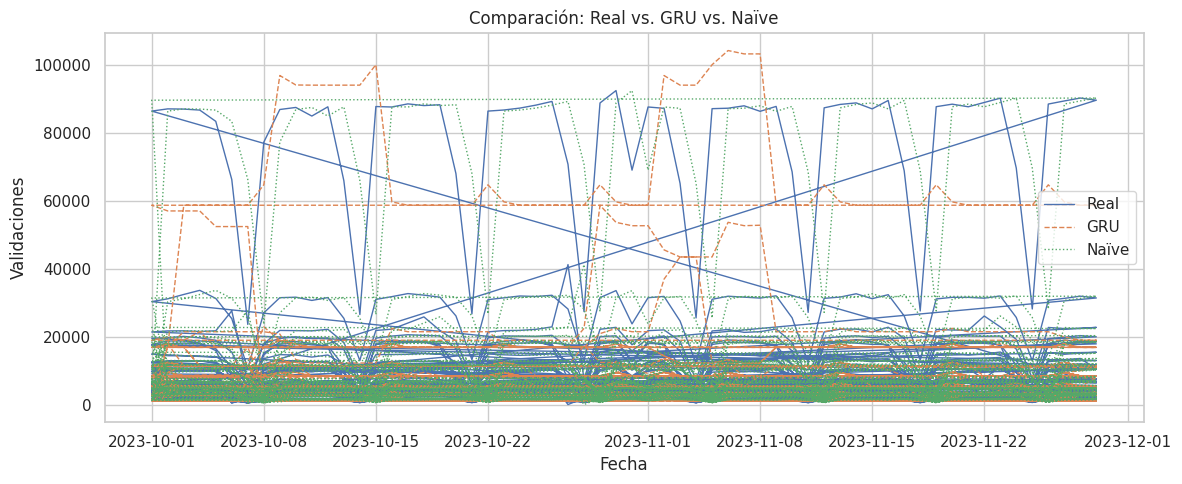

In [ ]:
# 1) Vuelve a predecir y desescalar en el scope global
pred = modelo_gru.predict(X_test)
pred_desescalado = scaler_target.inverse_transform(pred)               # shape (N,1)
y_test_desescalado = scaler_target.inverse_transform(y_test.reshape(-1,1))  # shape (N,1)

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# --- 1) Prepara los vectores "verdadero" y "predicción" sin lag ---
# y_test_desescalado: shape (N,1), pred_desescalado: shape (N,1)
y_true = y_test_desescalado.flatten()       # (N,)
y_pred = pred_desescalado.flatten()         # (N,)

# --- 2) Baseline Naïve simple (valor del día anterior) ---
naive_pred   = y_true[:-1]      # del índice 0 a N-2
y_true_cut   = y_true[1:]       # del índice 1 a N-1

# --- 3) Métricas del naïve ---
mae_naive  = mean_absolute_error(y_true_cut, naive_pred)
rmse_naive = np.sqrt(mean_squared_error(y_true_cut, naive_pred))
mape_naive = np.mean(np.abs((y_true_cut - naive_pred) / y_true_cut)) * 100

print(f"Naïve  – MAE: {mae_naive:.2f}, RMSE: {rmse_naive:.2f}, MAPE: {mape_naive:.1f}%")

# --- 4) Métricas de tu modelo ---
mae_model  = mean_absolute_error(y_true, y_pred)
rmse_model = np.sqrt(mean_squared_error(y_true, y_pred))
mape_model = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"GRU    – MAE: {mae_model:.2f}, RMSE: {rmse_model:.2f}, MAPE: {mape_model:.1f}%")

# --- 5) Gráfica comparativa ---
# Prepara eje de fechas compatible con el naïve (se desplaza 1 paso)
fechas_plot = fechas_test.iloc[n_lags+1 :].reset_index(drop=True)

plt.figure(figsize=(12,5))
plt.plot(fechas_plot, y_true_cut,    label="Real",    linewidth=1)
plt.plot(fechas_plot, y_pred[1:],    label="GRU",     linestyle='--', linewidth=1)
plt.plot(fechas_plot, naive_pred,    label="Naïve",   linestyle=':', linewidth=1)
plt.title("Comparación: Real vs. GRU vs. Naïve")
plt.xlabel("Fecha")
plt.ylabel("Validaciones")
plt.legend()
plt.tight_layout()
plt.show()


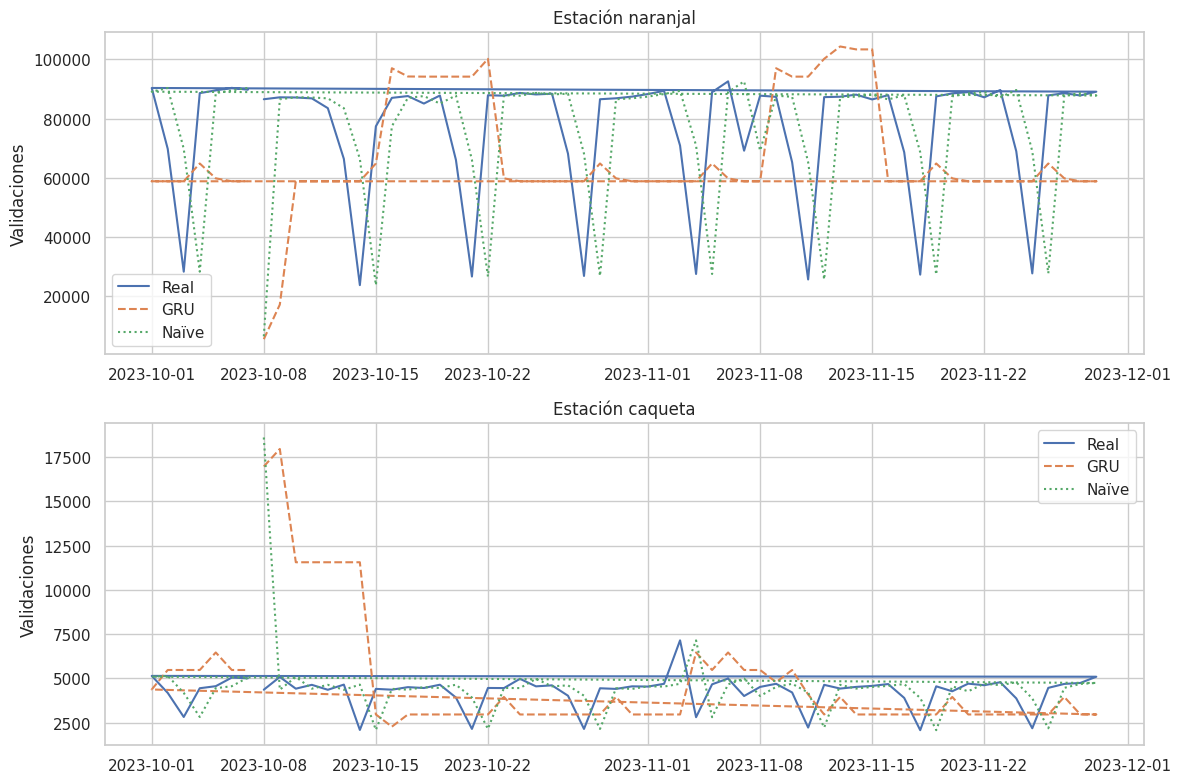

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Supongo que ya tienes:
# X_test, y_test (shape: [n_muestras, ...])
# y_pred (predicciones desescaladas, shape: [n_muestras, 1])
# fechas_test (serie de fechas antes de hacer ventanas, len = len(test_df))
# test_df (DataFrame original de test, antes de drop de object/datetime)

y_true_unscaled = scaler_target.inverse_transform(
    y_test.reshape(-1,1)
).flatten()

# 1) Alinea fechas con tus muestras:
n_lags = 7  # el mismo que usas para crear ventanas
fechas_alineadas = fechas_test[n_lags:].reset_index(drop=True)

# 2) Crea un DataFrame “de ventanas” que contenga:
#    - las dummy cols (para reconstruir estación)
#    - la fecha alineada
#    - los valores reales y predichos
df_windows = test_df.reset_index(drop=True).iloc[n_lags:].copy()
df_windows['fecha']   = fechas_alineadas
df_windows['y_true']  = y_true_unscaled
df_windows['y_pred']  = y_pred.flatten()
df_windows['y_naive'] = df_windows['y_true'].shift(1).bfill()

# 3) Reconstruye la estación “original” desde las dummies
dummy_cols = [c for c in df_windows.columns if c.startswith('est_')]
df_windows['estacion_rec'] = (
    df_windows[dummy_cols]
      .idxmax(axis=1)
      .str.replace('est_','')
)

# 4) Ahora sí, gráficalo estación a estación
import matplotlib.pyplot as plt
estaciones_a_mostrar = ['naranjal','caqueta']  # adapta

plt.figure(figsize=(12,4*len(estaciones_a_mostrar)))
for i, est in enumerate(estaciones_a_mostrar,1):
    dfp = df_windows[df_windows['estacion_rec']==est]
    plt.subplot(len(estaciones_a_mostrar),1,i)
    plt.plot(dfp['fecha'], dfp['y_true'],  label='Real')
    plt.plot(dfp['fecha'], dfp['y_pred'],  '--', label='GRU')
    plt.plot(dfp['fecha'], dfp['y_naive'], ':',  label='Naïve')
    plt.title(f'Estación {est}')
    plt.ylabel('Validaciones')
    plt.legend()
plt.tight_layout()
plt.show()


# Prueba 2

In [ ]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1) Define your model builder as before
def model_builder(hp):
    model = Sequential()
    model.add(Input(shape=X_train.shape[1:]))

    # Tipo de célula recurrente
    cell_type = hp.Choice("cell_type", ["LSTM", "GRU", "RNN"])

    # Unidades primera capa
    units_1 = hp.Int("units_1", min_value=32, max_value=128, step=32)

    # ¿Devolver secuencias para capa apilada?
    return_seq = hp.Boolean("return_sequences")

    if cell_type == "LSTM":
        model.add(LSTM(units_1, return_sequences=return_seq))
    elif cell_type == "GRU":
        model.add(GRU(units_1, return_sequences=return_seq))
    else:
        model.add(SimpleRNN(units_1, return_sequences=return_seq))

    # Capa recurrente adicional (opcional)
    if return_seq:
        units_2 = hp.Int("units_2", min_value=16, max_value=64, step=16)
        if cell_type == "LSTM":
            model.add(LSTM(units_2))
        elif cell_type == "GRU":
            model.add(GRU(units_2))
        else:
            model.add(SimpleRNN(units_2))

    # Dropout
    model.add(Dropout(hp.Float("dropout", 0.0, 0.5, step=0.1)))

    # Salida
    model.add(Dense(1, activation="linear"))

    # Optimizer & learning rate
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(optimizer=Adam(learning_rate=lr), loss="mae")

    return model

# 2) Configura el tuner con Bayesian Optimization
tuner = kt.BayesianOptimization(
    model_builder,
    objective="val_loss",
    max_trials=20,               # ajusta si quieres probar más combinaciones
    directory="tuner_logs",
    project_name="rnn_bayes_opt"
)

# 3) Lanza la búsqueda
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,               # puedes fijar batch_size o tunearlo por separado
    callbacks=[EarlyStopping(monitor="val_loss", patience=5)]
)

# 4) Obtén los mejores hiperparámetros
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Mejores hyperparámetros:", best_hp.values)

# 5) Construye y entrena el modelo final
best_model = tuner.hypermodel.build(best_hp)
best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,               # o usa best_hp.get("batch_size") si lo hubieras tunedo
    callbacks=[EarlyStopping(monitor="val_loss", patience=5)],
    verbose=1
)

# 6) Evalúa en test
pred = best_model.predict(X_test)
pred_des = scaler_target.inverse_transform(pred)
y_test_des = scaler_target.inverse_transform(y_test.reshape(-1,1))

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae  = mean_absolute_error(y_test_des, pred_des)
mse = mean_squared_error(y_test_des, pred_des)
rmse = np.sqrt(mse)
print(f"Best model (Bayesian) – MAE: {mae:.2f}, RMSE: {rmse:.2f}")


Trial 20 Complete [00h 05m 40s]
val_loss: 0.012931779958307743

Best val_loss So Far: 0.012931779958307743
Total elapsed time: 01h 12m 28s
Mejores hyperparámetros: {'cell_type': 'LSTM', 'units_1': 32, 'return_sequences': True, 'dropout': 0.1, 'lr': 0.0003738573394146117, 'units_2': 32}
Epoch 1/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0800 - val_loss: 0.0375
Epoch 2/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.0295 - val_loss: 0.0278
Epoch 3/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0230 - val_loss: 0.0218
Epoch 4/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0191 - val_loss: 0.0217
Epoch 5/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0170 - val_loss: 0.0200
Epoch 6/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0156 - val_loss: 0.0174
Epoch 7/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0153 - val_loss: 0.0188
Epoch 8/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.0150 - val_loss: 0.0184
Epoch 9/50

# Prueba 3

In [ ]:
# ================================
# 0) (Opcional) Instala Keras Tuner
# ================================
# %pip install --quiet keras-tuner

# ================================
# 1) IMPORTS
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    LSTM, GRU, SimpleRNN,
    Embedding, Flatten,
    Concatenate, Dropout, Dense
)
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# ================================
# 2) CARGA Y PREPARACIÓN INICIAL
# ================================
# 2.1) Subida interactiva y lectura
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)), dayfirst=True)

# 2.2) Normaliza nombres y convierte la fecha
df.columns   = df.columns.str.strip().str.lower().str.replace(' ', '_')
df['fecha']  = pd.to_datetime(df['fecha'], dayfirst=True, errors='coerce')
df.dropna(subset=['fecha'], inplace=True)

# ================================
# 3) GENERACIÓN DE FEATURES
# ================================
# 3.1) Variables temporales cíclicas
df['dia_semana'] = df['fecha'].dt.dayofweek
df['mes']        = df['fecha'].dt.month
df['mes_sin']    = np.sin(2*np.pi * df['mes'] / 12)
df['mes_cos']    = np.cos(2*np.pi * df['mes'] / 12)
df['dsem_sin']   = np.sin(2*np.pi * df['dia_semana'] / 7)
df['dsem_cos']   = np.cos(2*np.pi * df['dia_semana'] / 7)

# 3.2) Comprobación de columnas binarias preexistentes
required_bins = ['es_finde','feriado','vacaciones_escolares','eventos']
missing = [c for c in required_bins if c not in df.columns]
if missing:
    raise ValueError(f"Faltan estas columnas binarias en el CSV: {missing}")
# (Suponemos que 'es_finde','feriado','vacaciones_escolares','eventos' ya existen)

# ================================
# 4) LIMPIEZA DE VALIDACIONES
# ================================
mask_ok = df['validaciones'] >= 100
prom = (
    df[mask_ok]
      .groupby(['estacion','dia_semana'])['validaciones']
      .mean()
      .rename('prom_est')
      .reset_index()
)
df = df.merge(prom, on=['estacion','dia_semana'], how='left')
df['validaciones_clean'] = np.where(
    df['validaciones'] < 100,
    df['prom_est'],
    df['validaciones']
)
df.drop(columns=['prom_est'], inplace=True)

# ================================
# 5) TARGET t+1 y TRANSFORMACIÓN
# ================================
df = df.sort_values(['estacion','fecha'])
df['target']     = df.groupby('estacion')['validaciones_clean'].shift(-1)
df.dropna(subset=['target'], inplace=True)
df['log_target'] = np.log1p(df['target'])

# ================================
# 6) CODIFICACIÓN DE ESTACIÓN
# ================================
station_ids      = {s:i for i,s in enumerate(df['estacion'].unique())}
df['station_id'] = df['estacion'].map(station_ids)

# ================================
# 7) SPLIT TEMPORAL
# ================================
train_df = df[df['fecha'] < '2023-01-01']
val_df   = df[(df['fecha'] >= '2023-01-01') & (df['fecha'] < '2023-10-01')]
test_df  = df[df['fecha'] >= '2023-10-01']

# ================================
# 8) SELECCIÓN Y ESCALADO DE FEATURES y TARGET
# ================================
feat_cols = [
    'validaciones_clean','mes_sin','mes_cos','dsem_sin','dsem_cos',
    'es_finde','feriado','vacaciones_escolares','eventos'
]

# 8.1) Ajuste de scalers sólo con train
scaler_feat = MinMaxScaler().fit(train_df[feat_cols])
scaler_tgt  = StandardScaler().fit(train_df[['log_target']])

# 8.2) Transformación consistente en train/val/test
for d in (train_df, val_df, test_df):
    d[feat_cols]    = scaler_feat.transform(d[feat_cols])
    d['log_tgt_sc'] = scaler_tgt.transform(d[['log_target']])

# Guarda las fechas de test para gráficas posteriores
fechas_test = test_df['fecha'].reset_index(drop=True)

# ================================
# 9) PREPARA TF DATASETS
# ================================
n_lags, batch_size = 7, 16

def to_array(df_):
    return (
        df_[feat_cols].values.astype('float32'),
        df_['station_id'].values.astype('int32'),
        df_['log_tgt_sc'].values.astype('float32'),
    )

train_x, train_sid, train_y = to_array(train_df)
val_x,   val_sid,   val_y   = to_array(val_df)
test_x,  test_sid,  test_y  = to_array(test_df)

def make_dataset(x_arr, sid_arr, y_arr, shuffle):
    def gen():
        for i in range(n_lags, len(x_arr)):
            yield x_arr[i-n_lags:i], sid_arr[i], y_arr[i]
    sig = (
        tf.TensorSpec((n_lags, len(feat_cols)), tf.float32),
        tf.TensorSpec((),                tf.int32),
        tf.TensorSpec((),                tf.float32)
    )
    ds = tf.data.Dataset.from_generator(gen, output_signature=sig)
    if shuffle:
        ds = ds.shuffle(10_000)
    ds = ds.map(lambda x,s,y: ((x,s), y), tf.data.AUTOTUNE)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

ds_train = make_dataset(train_x, train_sid, train_y, shuffle=True)
ds_val   = make_dataset(val_x,   val_sid,   val_y, shuffle=False)
ds_test  = make_dataset(test_x,  test_sid,  test_y, shuffle=False)

# ================================
#10) DEFINICIÓN DEL MODEL BUILDER
# ================================
def model_builder(hp):
    cell_type  = hp.Choice("cell_type", ["LSTM","GRU","RNN"])
    units1     = hp.Int("units1", 32,128,step=32)
    return_seq = hp.Boolean("return_seq")
    units2     = hp.Int("units2", 16,64, step=16) if return_seq else None
    dropout    = hp.Float("dropout",0.0,0.5,step=0.1)
    emb_dim    = hp.Int("emb_dim",4,16,step=4)
    lr         = hp.Float("lr",1e-4,1e-2,sampling="log")

    seq_in  = Input((n_lags, len(feat_cols)))
    stat_in = Input((), dtype="int32")
    emb     = Embedding(len(station_ids), emb_dim)(stat_in)
    emb     = Flatten()(emb)

    # 1ª capa recurrente
    if cell_type=="LSTM":
        x = LSTM(units1, return_sequences=return_seq)(seq_in)
    elif cell_type=="GRU":
        x = GRU(units1, return_sequences=return_seq)(seq_in)
    else:
        x = SimpleRNN(units1, return_sequences=return_seq)(seq_in)

    # 2ª capa recurrente opcional
    if return_seq:
        if cell_type=="LSTM":
            x = LSTM(units2)(x)
        elif cell_type=="GRU":
            x = GRU(units2)(x)
        else:
            x = SimpleRNN(units2)(x)

    x   = Concatenate()([x, emb])
    x   = Dropout(dropout)(x)
    x   = Dense(hp.Int("dense_units",4,32,step=4), activation="relu")(x)
    out = Dense(1)(x)

    model = Model([seq_in, stat_in], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name="mape")]
    )
    return model

# ================================
#11) BÚSQUEDA DE HIPERPARÁMETROS
# ================================
tuner = kt.BayesianOptimization(
    model_builder,
    objective="val_mape",
    max_trials=10,
    directory="tuner_logs",
    project_name="metro_tuning"
)
tuner.search(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=[EarlyStopping("val_mape", patience=3)],
    verbose=1
)

# ================================
#12) REENTRENAR CON LOS MEJORES HP
# ================================
best_hp    = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

best_model.fit(
    ds_train.repeat(),
    validation_data=ds_val,
    epochs=50,
    steps_per_epoch=1000,
    callbacks=[EarlyStopping("val_mape", patience=7)],
    verbose=1
)

# ================================
#13) EVALUACIÓN FINAL EN TEST
# ================================
# 13.1) Predicción en escala log‑estandarizada
pred_log     = best_model.predict(ds_test)

# 13.2) Inversión de StandardScaler + log1p
pred_log_inv = scaler_tgt.inverse_transform(pred_log)
y_pred       = np.expm1(pred_log_inv.flatten())

# 13.3) Alinea los verdaderos (se ignoran los primeros n_lags)
y_true       = test_df['target'].iloc[n_lags:].values
assert len(y_true)==len(y_pred), "Desajuste en longitudes de y_true/y_pred"

# 13.4) Cálculo de métricas en escala original
mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred) * 100

print(f"TEST → MAE:  {mae:.2f}")
print(f"       RMSE: {rmse:.2f}")
print(f"       MAPE: {mape:.2f}%")

# ================================
#14) VALIDACIÓN POR ESTACIÓN (opcional)
# ================================
# Construye df de diagnóstico
dfw = test_df.reset_index(drop=True).iloc[n_lags:].copy()
dfw['fecha']   = fechas_test.iloc[n_lags:].reset_index(drop=True)
dfw['y_true']  = y_true
dfw['y_pred']  = y_pred
dfw['y_naive'] = dfw['y_true'].shift(1).bfill()
dfw['estacion']= dfw['station_id'].map({v:k for k,v in station_ids.items()})

# Calcula y muestra métricas por estación
metrics = []
for est, grp in dfw.groupby('estacion'):
    yt, yp, yn = grp['y_true'], grp['y_pred'], grp['y_naive']
    mae_m = mean_absolute_error(yt, yp)
    mape_m= mean_absolute_percentage_error(yt, yp)*100
    mae_n = mean_absolute_error(yt, yn)
    mejora = (mae_n - mae_m)/mae_n*100
    metrics.append((est, mae_m, mape_m, mejora))

metrics_df = pd.DataFrame(metrics, columns=['estacion','MAE','MAPE (%)','Mejora MAE (%)'])\
               .sort_values('Mejora MAE (%)', ascending=False)
print(metrics_df)

# Gráfica de ejemplo de dos estaciones
plt.figure(figsize=(12,8))
for i, est in enumerate(['naranjal','caqueta'], 1):
    sub = dfw[dfw['estacion']==est]
    plt.subplot(2,1,i)
    plt.plot(sub['fecha'], sub['y_true'],  label='Real')
    plt.plot(sub['fecha'], sub['y_pred'],  '--', label='Modelo')
    plt.plot(sub['fecha'], sub['y_naive'], ':',  label='Naïve')
    plt.title(f"{est.title()} — MAPE {mean_absolute_percentage_error(sub.y_true, sub.y_pred)*100:.1f}%")
    plt.legend()
plt.tight_layout()
plt.show()
